In [1]:
from matplotlib.pyplot import yscale
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from matplotlib import cm
import numpy as np
import pandas as pd
import lightkurve as lk
from altaipony.flarelc import FlareLightCurve
from lightkurve.lightcurvefile import TessLightCurveFile
from lightkurve.lightcurve import TessLightCurve
from altaipony.ffd import FFD

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
stats = ['ID','Top_Period','Top_Period_Power','Fap_99','Is_Harmonic','Num_Flares','Is_Powerlaw']
ids = []
top_periods = []
top_period_powers = []
fap_99s = []
is_harmonic = []
num_flares = []
is_powerlaw = []

In [3]:
%matplotlib inline

In [7]:
def make_plot(tic_id, data_dir): 
    
    ids.append(tic_id)
    lc_df = pd.read_csv(data_dir+'/TIC '+tic_id+'.CSV')
    ls_df = lc_df[['time', 'flux', 'flux_err']]

    ls_df = ls_df.dropna()

    raw_times = np.array(ls_df['time'])
    raw_fluxes = np.array(ls_df['flux'])
    raw_flux_errs = np.array(ls_df['flux_err'])
    
    light_curve = lk.LightCurve(time=raw_times, flux=raw_fluxes, flux_err=raw_flux_errs)
    light_curve = light_curve.remove_outliers(sigma=3).normalize()

    times = np.array(light_curve.time.value)
    fluxes = np.array(light_curve.flux.value)
    flux_errs = np.array(light_curve.flux_err)
    
    # FIX to use detrended / clipped lc

    ### MAKE PLOT
    plt.style.use('C:/Users/60002/Documents/GitHub/sunnyhills/other/aesthetics/science.mplstyle') # set style...should work on all our computers because relative

    # try with "root path" set to "./other/aesthetics/science.mplstyle"

    mosaic = """
        AAB
        CCD
        EEF
        """

    fig = plt.figure(constrained_layout=True, figsize=(12,6))
    ax_dict = fig.subplot_mosaic(mosaic)

    # A is raw light curve
    ax_dict['A'].scatter(raw_times, raw_fluxes, s=3)
    ax_dict['A'].set(xlabel='Time (d)', ylabel='Raw Normalized Flux')

    # to axis one of the subplots, do it like this: ax_dict['A'] (e.g. for subplot A)

    # lomb-periodogram 
    # max frequency = observation window / 3
    # min frequency = ???

    # ls won't work when nans in array 
    
    window_length = np.max(times)-np.min(times)
    periodogram = LombScargle(times, fluxes, flux_errs)

    false_alarm_levels = [0.01]
    faps = periodogram.false_alarm_level(false_alarm_levels)

    frequencies, powers = periodogram.autopower(minimum_frequency=3/window_length, maximum_frequency=10)
    # max freq and min freq 
    periods = 1/frequencies 

    
    lc = FlareLightCurve(raw_times,raw_fluxes,raw_flux_errs,mission='TESS')

    detrended = lc.detrend("savgol")
    detrended = detrended.find_flares()
    simple_ffd= FFD(f=detrended.flares)

    simple_ffd.tot_obs_time = 20
    ed, freq,count= simple_ffd.ed_and_freq()

    ax_dict['B'].scatter(ed, freq)
    ax_dict['B'].set(xscale="log",yscale="log")
    ax_dict['B'].set(xLabel="ED [s]",yLabel="cumulative num of flares")

    try:
        simple_ffd.fit_powerlaw("mmle")
        simple_ffd.plot_powerlaw(ax_dict['B'], c="r", label=fr'$\alpha=$-{simple_ffd.alpha:.1f}')
        is_powerlaw.append(simple_ffd.is_powerlaw(sig_level=.05))
    except ValueError:
        is_powerlaw.append(False)
    except ZeroDivisionError:
        is_powerlaw.append(False)

    num_flares.append(detrended.flares.shape[0])
    try:
        for start,stop in zip(detrended.flares['tstart'],detrended.flares['tstop']):
            ax_dict['C'].axvline(x=start,c="green", label='Flare Start')
            ax_dict['C'].axvline(x=stop,c="red",label='Flare Stop')
    except IndexError:
        print('no flares!')
    ax_dict['C'].plot(times,fluxes)
    
        
    # add FAP and harmonic notatio

    ax_dict['D'].plot(periods, powers)
    
    ax_dict['D'].set(xlabel='Period (d)', ylabel='Power')#, yscale='log')

    grey_colors = ['lightgray','darkgray','dimgrey']
    for i in range(len(false_alarm_levels)-1,-1,-1): # Plot them in reverse order so the highest confidence label is 
        #confidence_label = str(100*(1-false_alarm_levels[i]))+'% FAP'
        ax_dict['D'].axhline(y=(faps[i]), xmin=1/10, xmax=window_length/3, color = grey_colors[i],lw=1)
    
 
    fap_99 = faps[0]
    more_than_fap_mask = np.where(powers>fap_99)
    periods = periods[more_than_fap_mask]
    powers = powers[more_than_fap_mask]
    sorted_indices = np.argsort(powers)[::-1]
    sorted_powers = powers[sorted_indices][0:20]
    sorted_periods = periods[sorted_indices][0:20]
    if len(sorted_periods)>0: 
        best_period = sorted_periods[0] # get period corresponding to highest power
        best_period_power = sorted_powers[0]
    else: 
        best_period = 0
        best_period_power = 0
    has_harmonic = False 
    if best_period != 0: 
        for i in range(2,6): 
            lower = best_period/i
            upper = best_period*i
            for test_period in sorted_periods: 
                lower_ratio = lower/test_period
                upper_ratio = test_period/upper
                if 1.01 > lower_ratio > 0.99: 
                    has_harmonic = True
                    ax_dict['D'].axvline(x=lower, ymin=0.8, ymax=1, color='indianred', lw=0.75) # replace with red x line midway through plot
                
                
                
                elif 0.99 < upper_ratio < 1.01: 
                    ax_dict['D'].axvline(x=upper, ymin=0.8, ymax=1, color='indianred', lw=0.75)
                    has_harmonic = True
    # sigma clipped light curve 
    ax_dict['E'].scatter(times, fluxes, s=3)
    ax_dict['E'].set(xlabel='Time (d)', ylabel=r'$/sigma$'+'-clipped Normalized Flux')
    e_xlabel = 'Phase (P='+str(round(best_period,2))+' d)'
    if best_period != 0: 
        phased_dates = np.mod(times, best_period)/best_period # phase the dates
        ax_dict['F'].scatter(phased_dates, fluxes, s=3)
        
    else: 
        e_xlabel = 'Phase (P= nan d)'
    ax_dict['F'].set(xlabel=e_xlabel, ylabel='Normalized Flux (FIX)')

    top_periods.append(best_period)
    fap_99s.append(fap_99)
    is_harmonic.append(has_harmonic)
    top_period_powers.append(best_period_power)
    # metadata to save after each iteration: 
    '''

    Note: end results for the entire iteration should be one .csv with id column and columns for the parameters below, which are populated by row/ID basis  

    LombScargle Related: 
    > top_period
    > top_period_power
    > fap_99 
    > top period is harmonic (True/False) # fix because is vs possesses is different 
    
    Flare Related: 
    > add number of flares

    '''


    plt.show()
    #plt.imsave('C:/Users/60002/Documents/GitHub/sunnyhills/data/Mosaic_plots/'+tic_id)
    fig.savefig('C:/Users/60002/Documents/GitHub/sunnyhills/data/New_mosaics/'+tic_id,transparent=False,facecolor="white")
    ## LC MOSAIC KEY FOR NOW 
    """
    A: raw light curve 
    B: flare frequency plot
    C: raw light curve with annotated flares
    D: periodogram with annotated harmonics # detrending is doing weird things
    E: iterative 3 sigma clipped light curve
    F: Phase folded light curve 
    """


In [5]:
#lc_dir = 'C:/Users/60004/Documents/GitHub/sunnyhills/data/LightCurve_keys'
#tic_id = '118807628'
#make_plot(tic_id, lc_dir)


C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 29 candidate(s) in the (0,7150) gap.
Found 15 candidate(s) in the (7150,14209) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 44.
Setting frequency values with new values, size 44.
Setting frequency adjusted count values with new values, size 44.


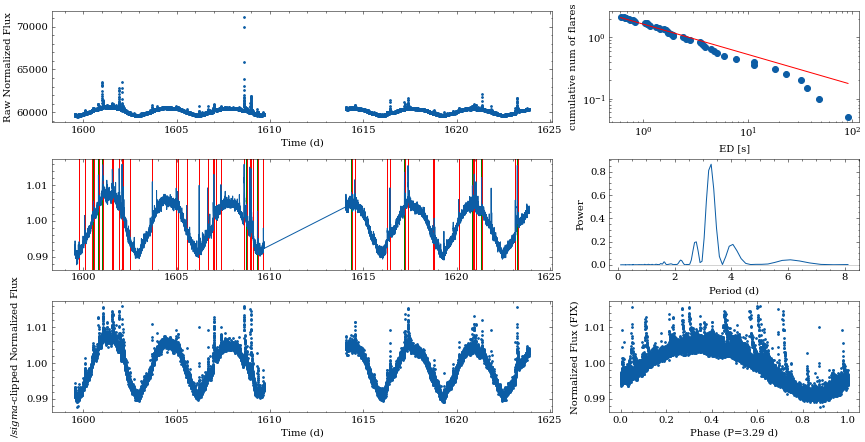

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 43 candidate(s) in the (0,9409) gap.
Found 40 candidate(s) in the (9409,18277) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 83.
Setting frequency values with new values, size 83.
Setting frequency adjusted count values with new values, size 83.


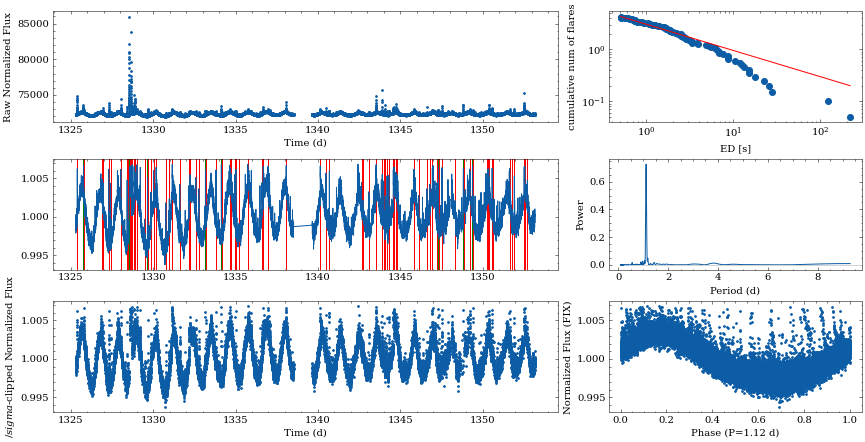

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 48 candidate(s) in the (0,8168) gap.
Found 56 candidate(s) in the (8168,16334) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 104.
Setting frequency values with new values, size 104.
Setting frequency adjusted count values with new values, size 104.


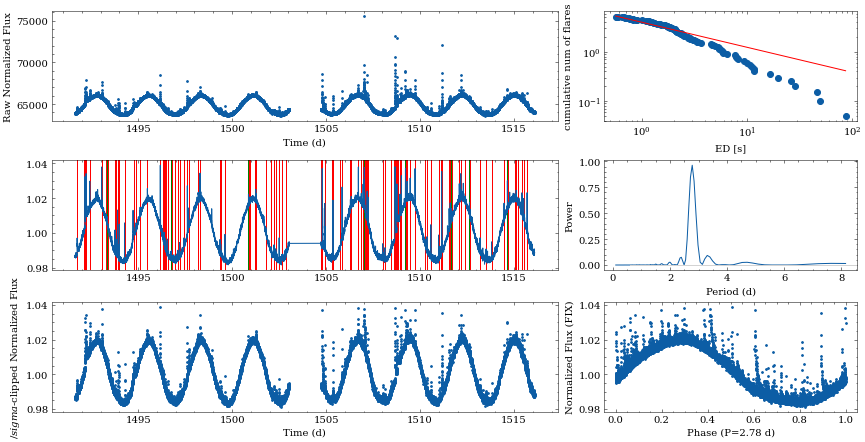

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 20 candidate(s) in the (0,8056) gap.
Found 16 candidate(s) in the (8056,15869) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 36.
Setting frequency values with new values, size 36.
Setting frequency adjusted count values with new values, size 36.


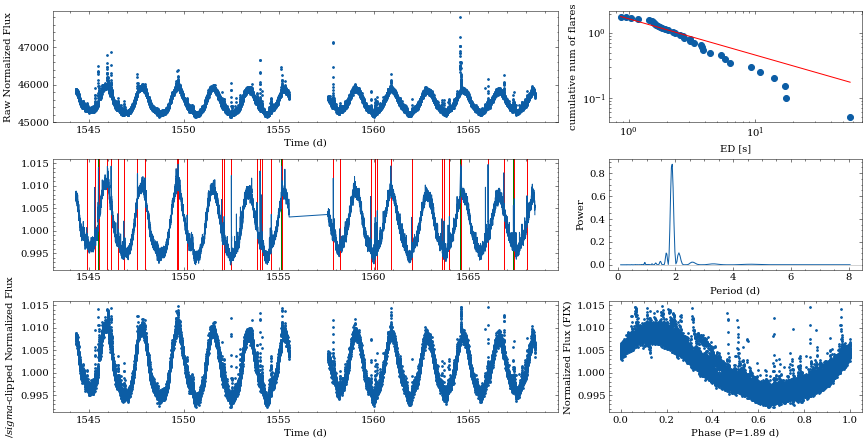

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 9 candidate(s) in the (0,8537) gap.
Found 9 candidate(s) in the (8537,17241) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 18.
Setting frequency values with new values, size 18.
Setting frequency adjusted count values with new values, size 18.


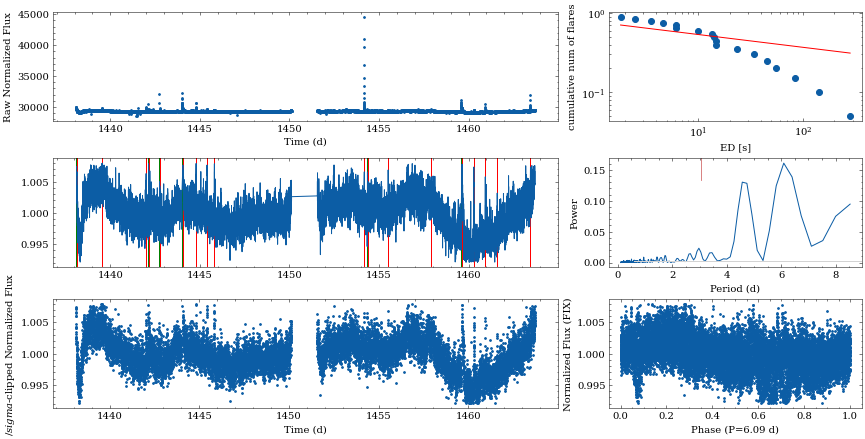

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 4 candidate(s) in the (0,85) gap.
Found 1 candidate(s) in the (85,210) gap.
Found 1 candidate(s) in the (210,401) gap.
Found 2 candidate(s) in the (401,463) gap.
Found 0 candidate(s) in the (463,514) gap.
Found 2 candidate(s) in the (514,573) gap.
Found 1 candidate(s) in the (573,696) gap.
Found 0 candidate(s) in the (696,759) gap.
Found 1 candidate(s) in the (759,820) gap.
Found 0 candidate(s) in the (820,939) gap.
Found 1 candidate(s) in the (939,1001) gap.
Found 0 candidate(s) in the (1001,1121) gap.
Found 1 candidate(s) in the (1121,1383) gap.
Found 6 candidate(s) in the (1383,1573) gap.
Found 1 candidate(s) in the (1573,1757) gap.
Found 1 candidate(s) in the (1757,1820) gap.
Found 0 candidate(s) in the (1820,1880) gap.
Found 0 ca

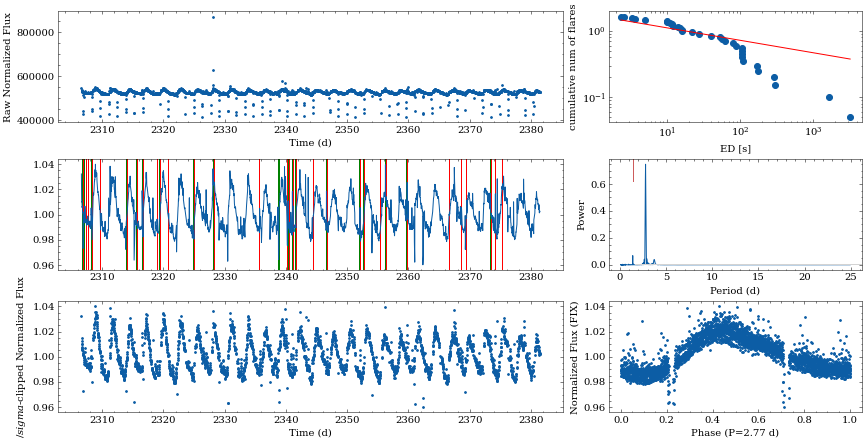

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 11 candidate(s) in the (0,6345) gap.
Found 14 candidate(s) in the (6345,12584) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 25.
Setting frequency values with new values, size 25.
Setting frequency adjusted count values with new values, size 25.


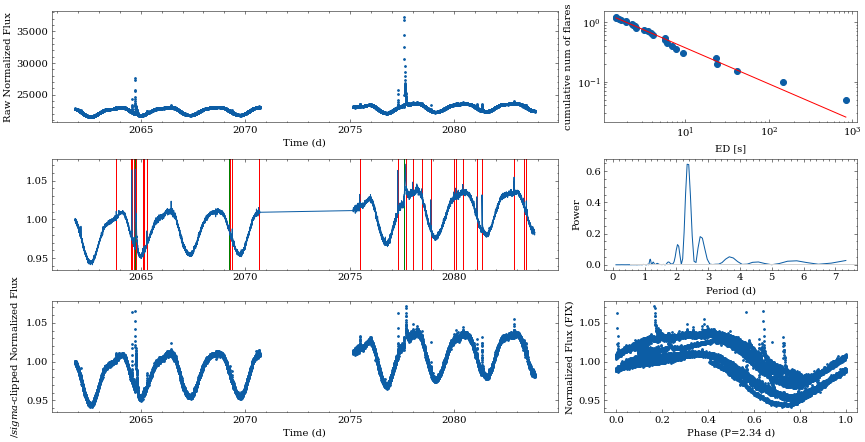

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 6 candidate(s) in the (0,6252) gap.
Found 16 candidate(s) in the (6252,12319) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 22.
Setting frequency values with new values, size 22.
Setting frequency adjusted count values with new values, size 22.


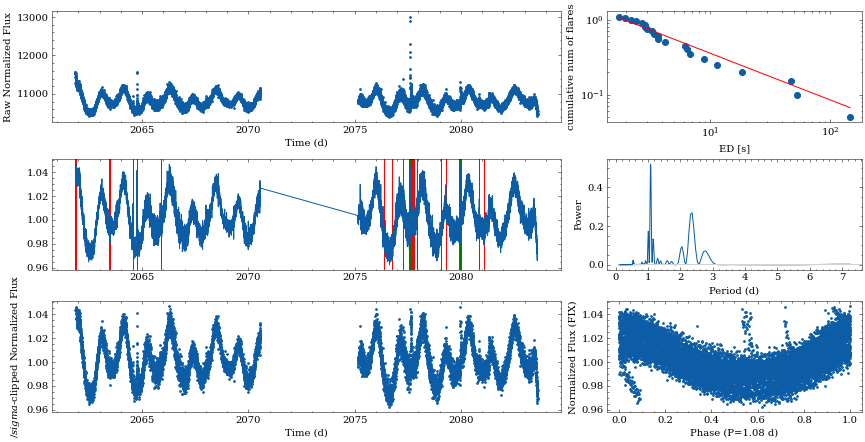

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 36 candidate(s) in the (0,8795) gap.
Found 22 candidate(s) in the (8795,16565) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 58.
Setting frequency values with new values, size 58.
Setting frequency adjusted count values with new values, size 58.


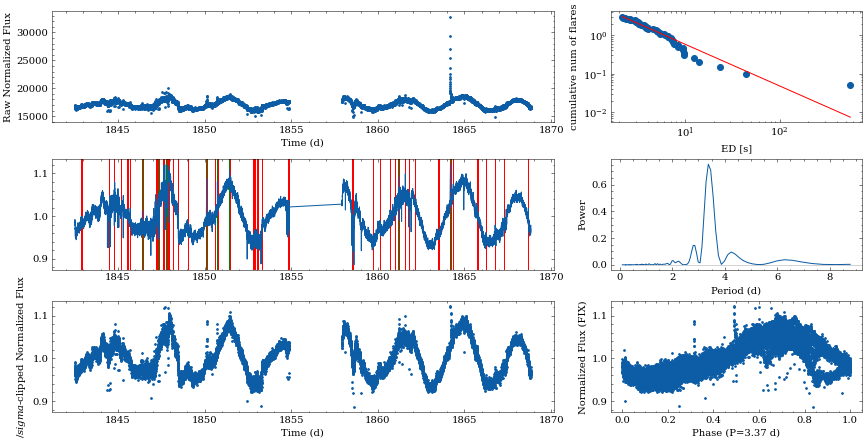

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 161 candidate(s) in the (0,9409) gap.
Found 171 candidate(s) in the (9409,18277) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 332.
Setting frequency values with new values, size 332.
Setting frequency adjusted count values with new values, size 332.


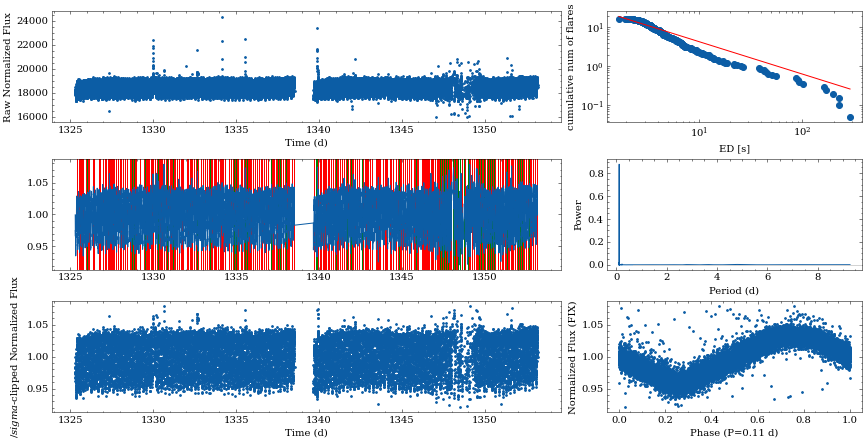

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 7 candidate(s) in the (0,8476) gap.
Found 11 candidate(s) in the (8476,17110) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 18.
Setting frequency values with new values, size 18.
Setting frequency adjusted count values with new values, size 18.


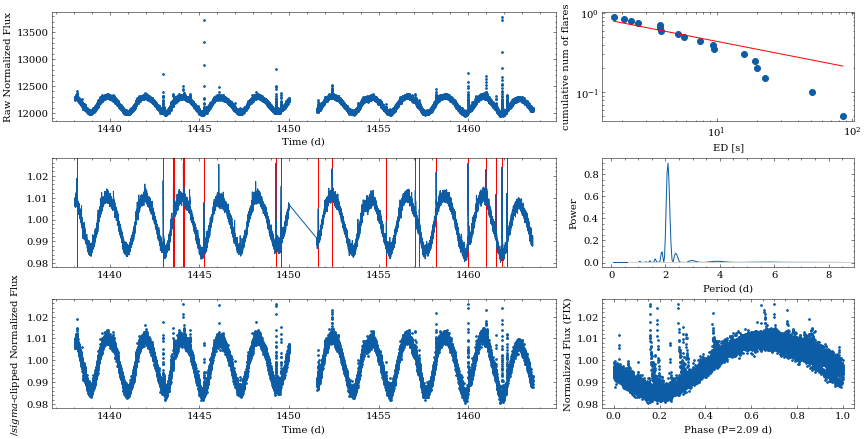

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 11 candidate(s) in the (0,7974) gap.
Found 8 candidate(s) in the (7974,15620) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 19.
Setting frequency values with new values, size 19.
Setting frequency adjusted count values with new values, size 19.


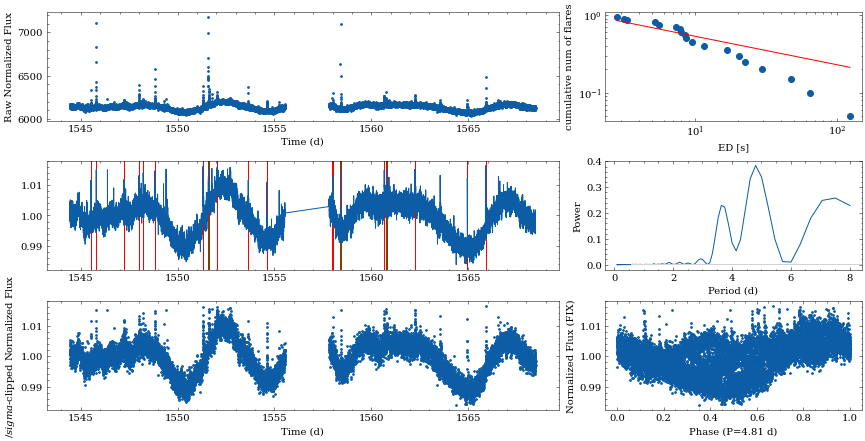

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 52 candidate(s) in the (0,8271) gap.
Found 44 candidate(s) in the (8271,16228) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 96.
Setting frequency values with new values, size 96.
Setting frequency adjusted count values with new values, size 96.


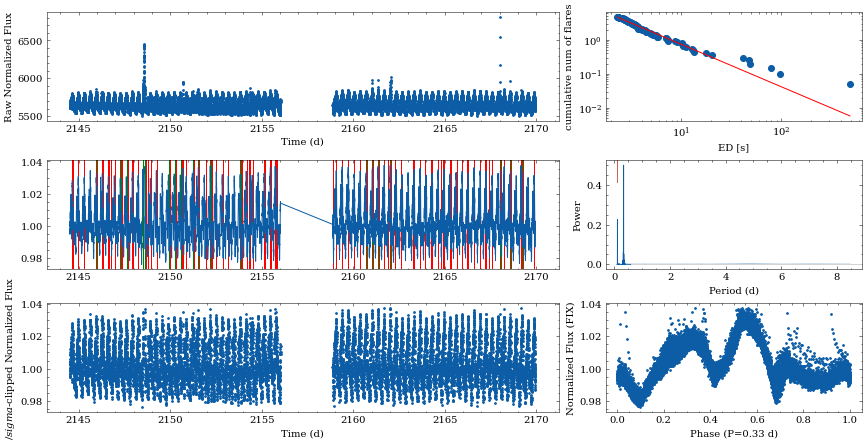

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 3 candidate(s) in the (0,9712) gap.
Found 4 candidate(s) in the (9712,19439) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 7.
Setting frequency values with new values, size 7.
Setting frequency adjusted count values with new values, size 7.


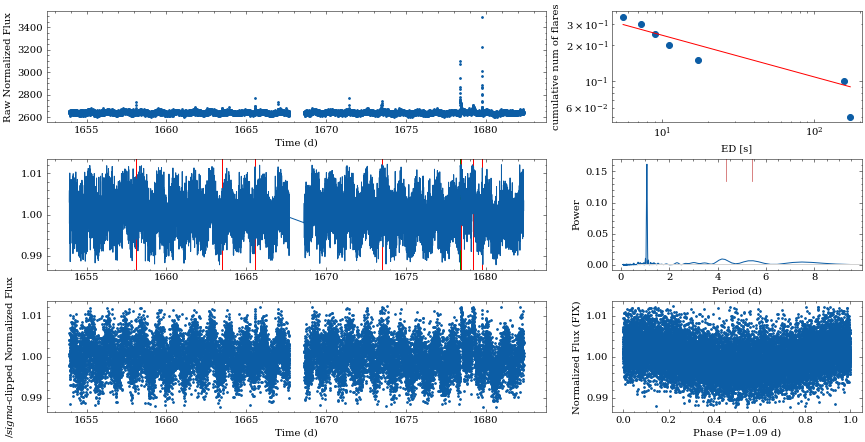

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 8 candidate(s) in the (0,8535) gap.
Found 9 candidate(s) in the (8535,17216) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 17.
Setting frequency values with new values, size 17.
Setting frequency adjusted count values with new values, size 17.


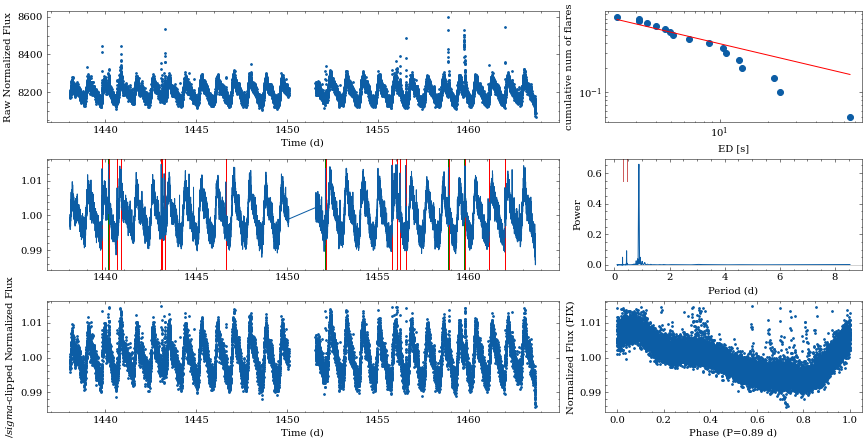

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 3 candidate(s) in the (0,8795) gap.
Found 6 candidate(s) in the (8795,16489) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 9.
Setting frequency values with new values, size 9.
Setting frequency adjusted count values with new values, size 9.


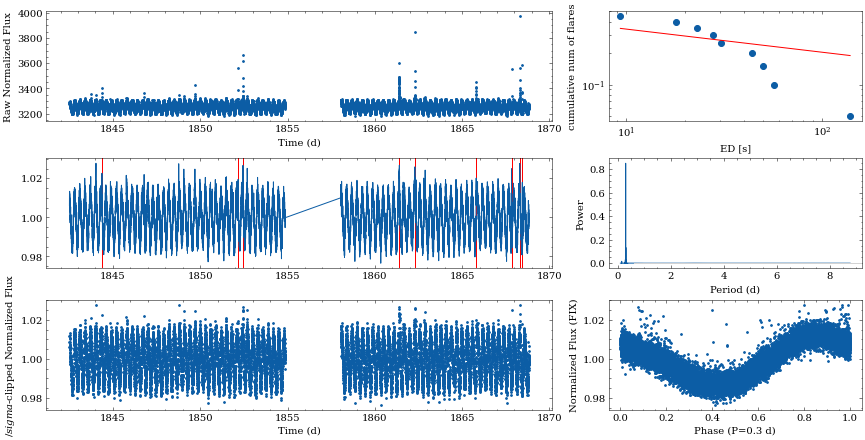

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 3 candidate(s) in the (0,7370) gap.
Found 4 candidate(s) in the (7370,14800) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 7.
Setting frequency values with new values, size 7.
Setting frequency adjusted count values with new values, size 7.


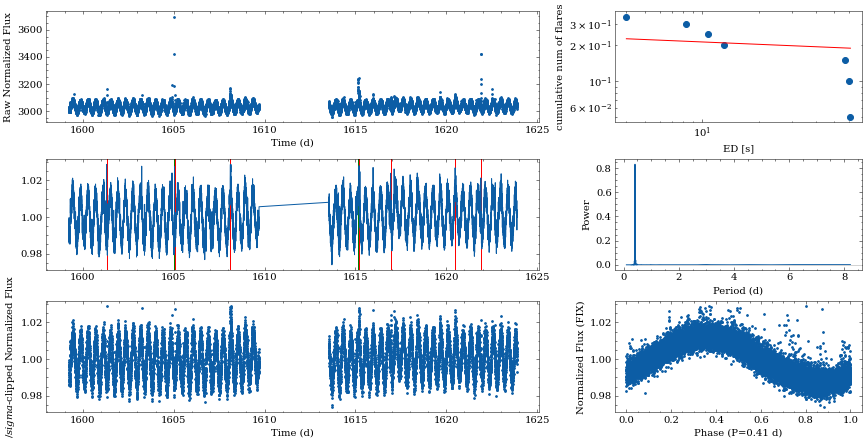

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 4 candidate(s) in the (0,7334) gap.
Found 1 candidate(s) in the (7334,8980) gap.
Found 8 candidate(s) in the (8980,16278) gap.
Found 0 candidate(s) in the (16278,17156) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 13.
Setting frequency values with new values, size 13.
Setting frequency adjusted count values with new values, size 13.


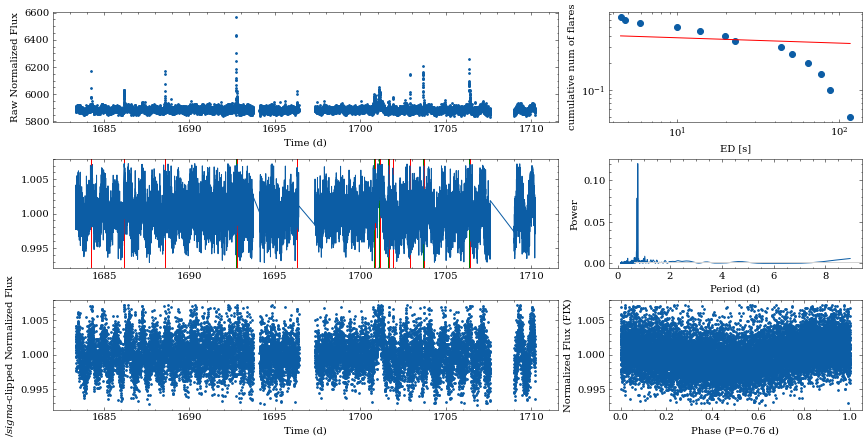

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 10 candidate(s) in the (0,6168) gap.
Found 10 candidate(s) in the (6168,14638) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 20.
Setting frequency values with new values, size 20.
Setting frequency adjusted count values with new values, size 20.


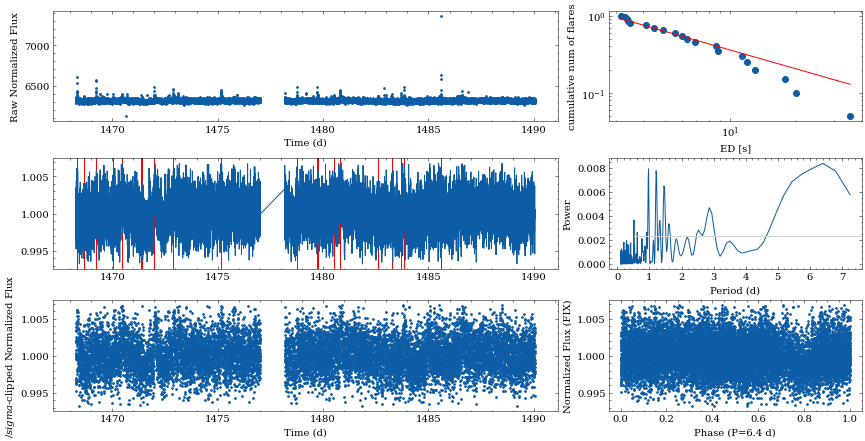

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 4 candidate(s) in the (0,8505) gap.
Found 3 candidate(s) in the (8505,17207) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 7.
Setting frequency values with new values, size 7.
Setting frequency adjusted count values with new values, size 7.


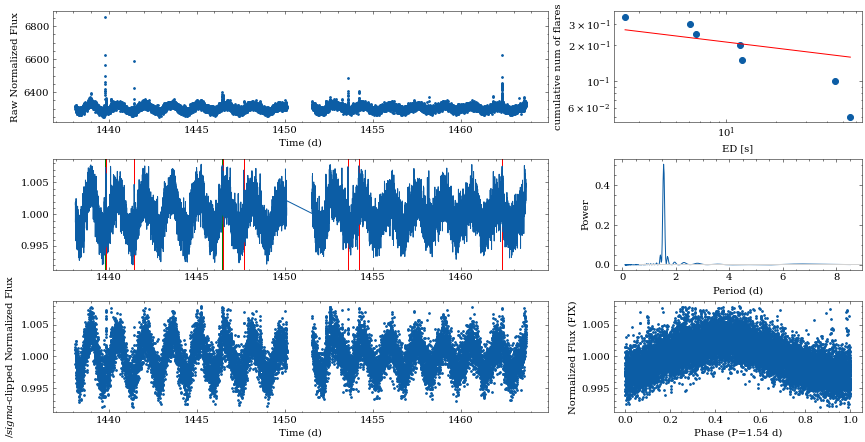

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,8440) gap.
Found 2 candidate(s) in the (8440,17103) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 2.
Setting frequency values with new values, size 2.
Setting frequency adjusted count values with new values, size 2.


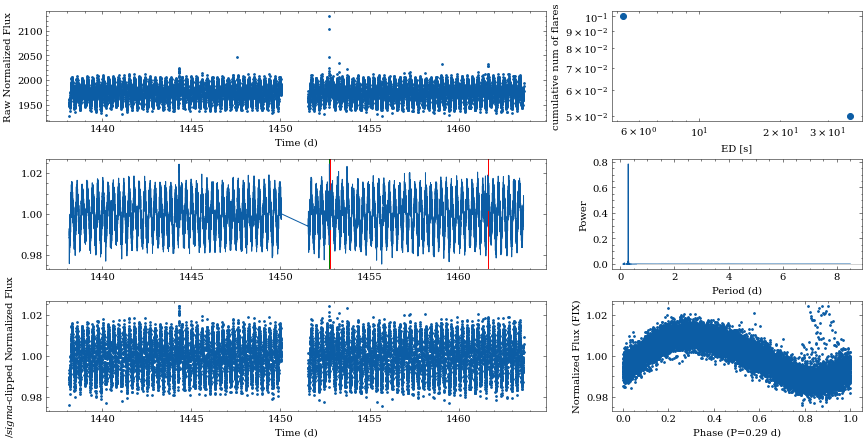

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 3 candidate(s) in the (0,1879) gap.
Found 1 candidate(s) in the (1879,3544) gap.
Found 0 candidate(s) in the (3544,3633) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 4.
Setting frequency values with new values, size 4.
Setting frequency adjusted count values with new values, size 4.


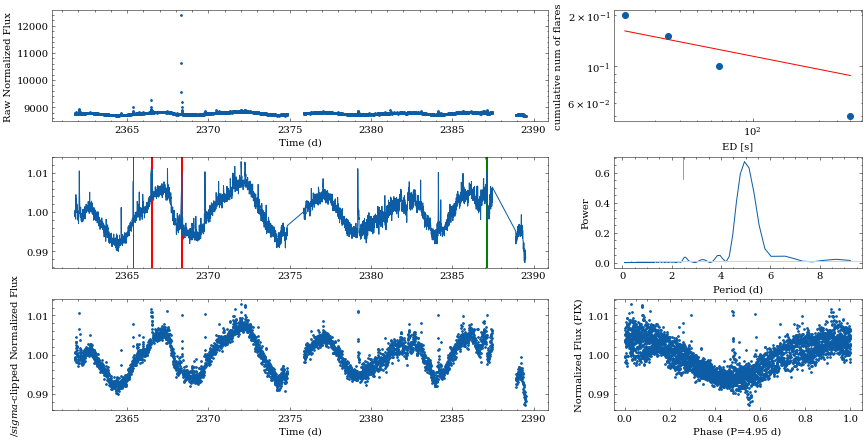

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 6 candidate(s) in the (0,7943) gap.
Found 6 candidate(s) in the (7943,12970) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 12.
Setting frequency values with new values, size 12.
Setting frequency adjusted count values with new values, size 12.


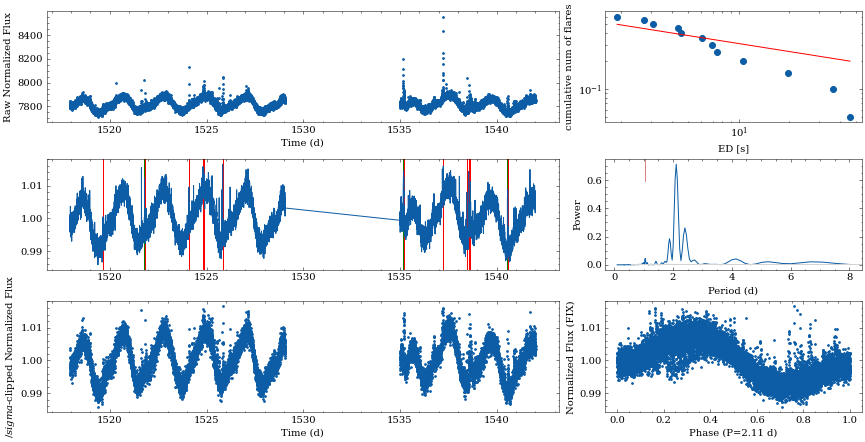

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 13 candidate(s) in the (0,9712) gap.
Found 17 candidate(s) in the (9712,19379) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 30.
Setting frequency values with new values, size 30.
Setting frequency adjusted count values with new values, size 30.


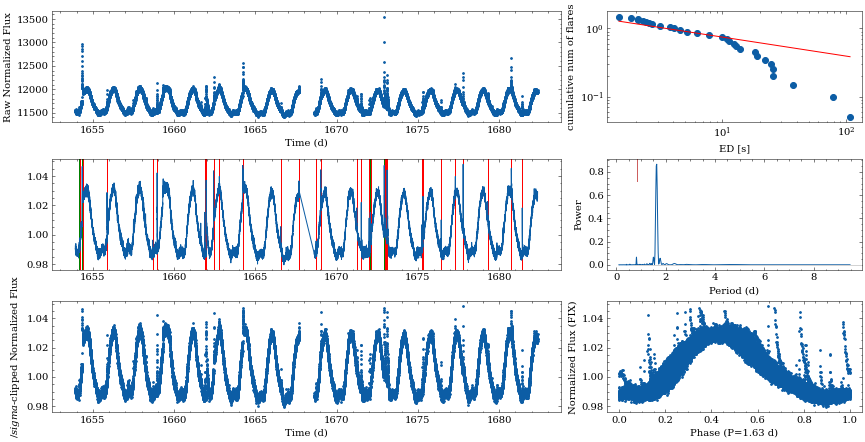

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,669) gap.
Found 0 candidate(s) in the (669,1266) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 0.
Setting frequency values with new values, size 0.
Setting frequency adjusted count values with new values, size 0.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:468: RuntimeWarning: Mean of empty slice.
  alpha = _alpha.mean()
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


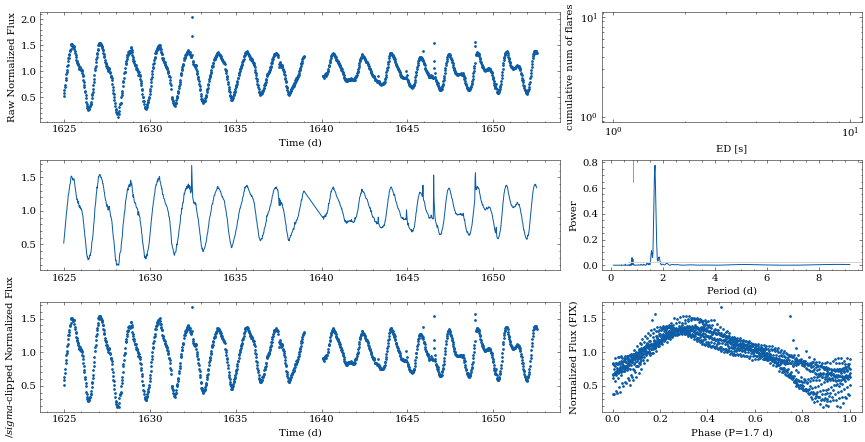

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,9226) gap.
Found 0 candidate(s) in the (9226,18300) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 0.
Setting frequency values with new values, size 0.
Setting frequency adjusted count values with new values, size 0.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:468: RuntimeWarning: Mean of empty slice.
  alpha = _alpha.mean()
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


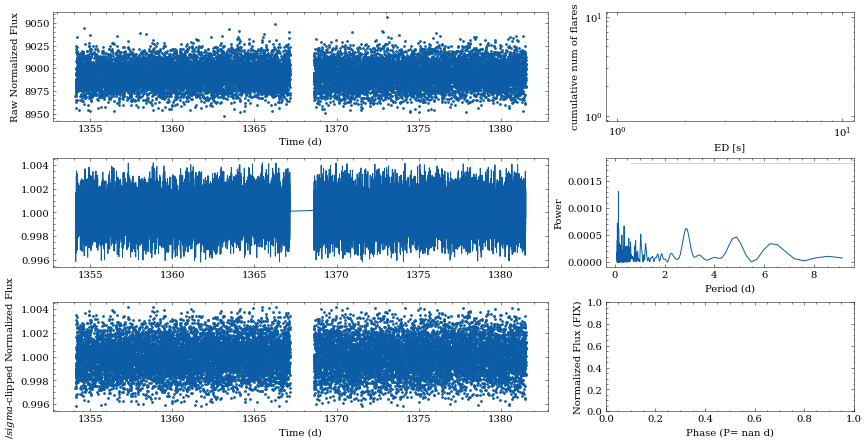

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,8160) gap.
Found 0 candidate(s) in the (8160,15280) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 0.
Setting frequency values with new values, size 0.
Setting frequency adjusted count values with new values, size 0.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:468: RuntimeWarning: Mean of empty slice.
  alpha = _alpha.mean()
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


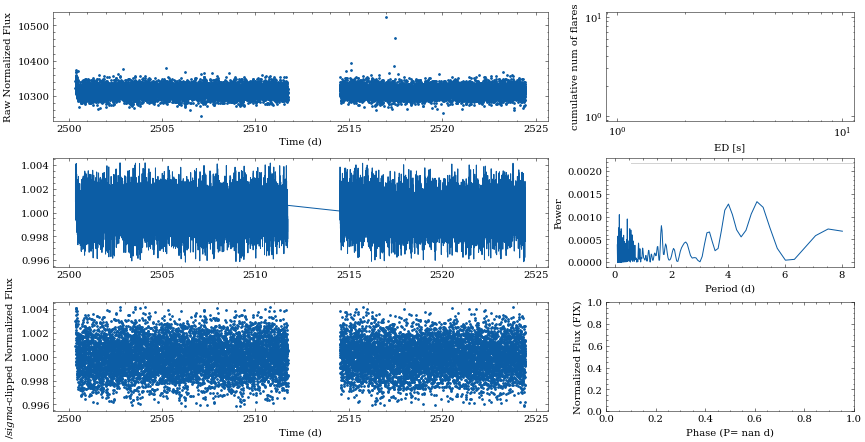

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 1 candidate(s) in the (0,1702) gap.
Found 2 candidate(s) in the (1702,3351) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 3.
Setting frequency values with new values, size 3.
Setting frequency adjusted count values with new values, size 3.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:905: RuntimeWarning: divide by zero encountered in true_divide
  return (alpha - 1.) * n / (n - 2) + 1.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:845: RuntimeWarning: invalid value encountered in true_divide
  (Zexp - Yexp)) -


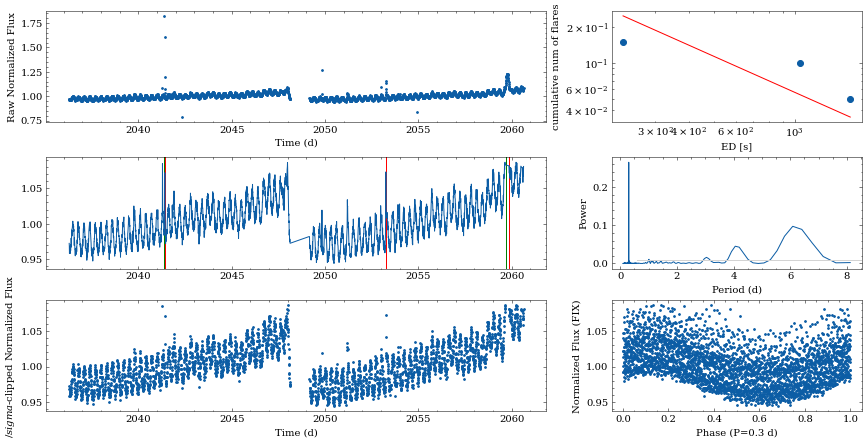

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 1 candidate(s) in the (0,1735) gap.
Found 2 candidate(s) in the (1735,3461) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 3.
Setting frequency values with new values, size 3.
Setting frequency adjusted count values with new values, size 3.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:905: RuntimeWarning: divide by zero encountered in true_divide
  return (alpha - 1.) * n / (n - 2) + 1.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:845: RuntimeWarning: invalid value encountered in true_divide
  (Zexp - Yexp)) -


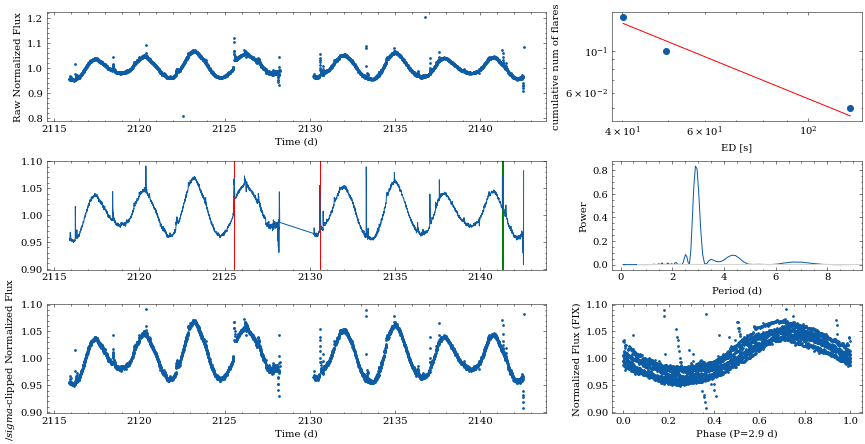

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,528) gap.
Found 1 candidate(s) in the (528,1037) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 1.
Setting frequency values with new values, size 1.
Setting frequency adjusted count values with new values, size 1.


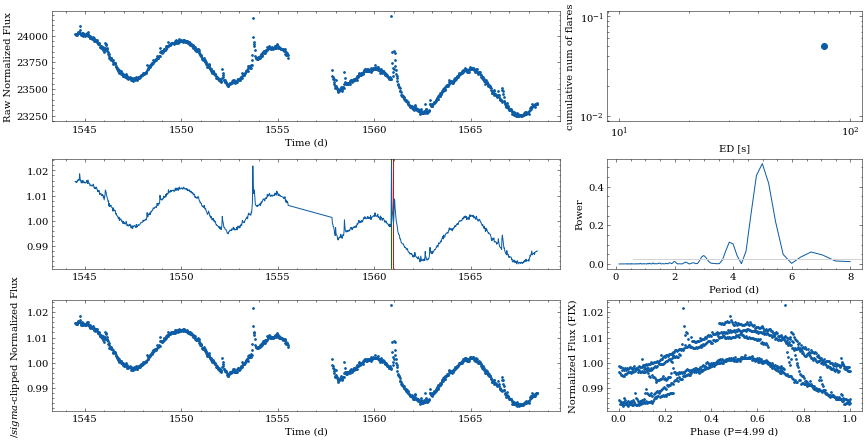

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 7 candidate(s) in the (0,9226) gap.
Found 9 candidate(s) in the (9226,17869) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 16.
Setting frequency values with new values, size 16.
Setting frequency adjusted count values with new values, size 16.


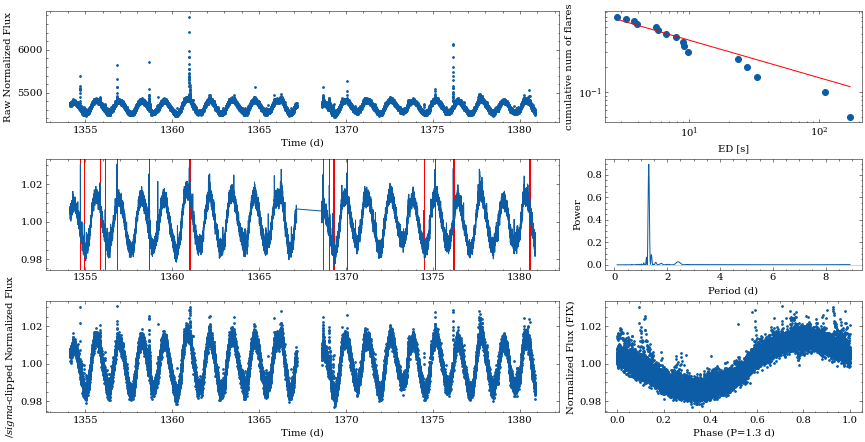

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 8 candidate(s) in the (0,6169) gap.
Found 11 candidate(s) in the (6169,14635) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 19.
Setting frequency values with new values, size 19.
Setting frequency adjusted count values with new values, size 19.


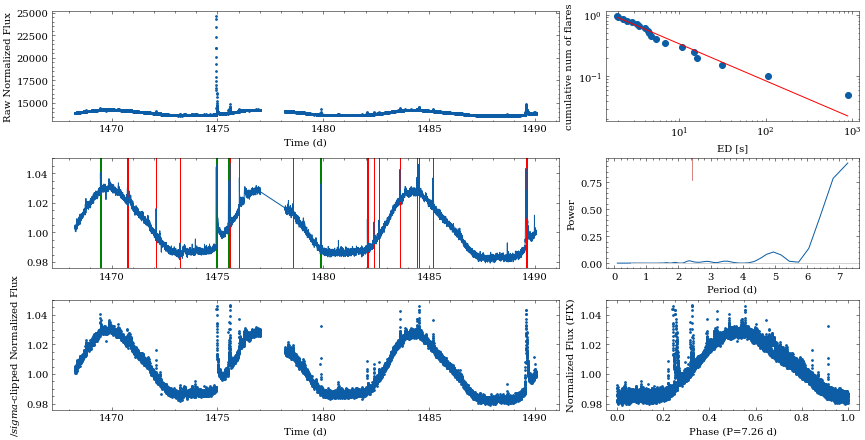

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 25 candidate(s) in the (0,9225) gap.
Found 27 candidate(s) in the (9225,18299) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 52.
Setting frequency values with new values, size 52.
Setting frequency adjusted count values with new values, size 52.


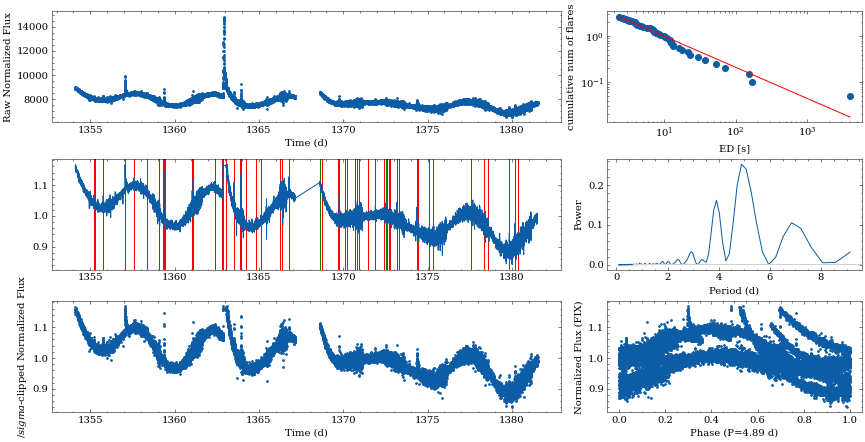

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 24 candidate(s) in the (0,9225) gap.
Found 13 candidate(s) in the (9225,18299) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 37.
Setting frequency values with new values, size 37.
Setting frequency adjusted count values with new values, size 37.


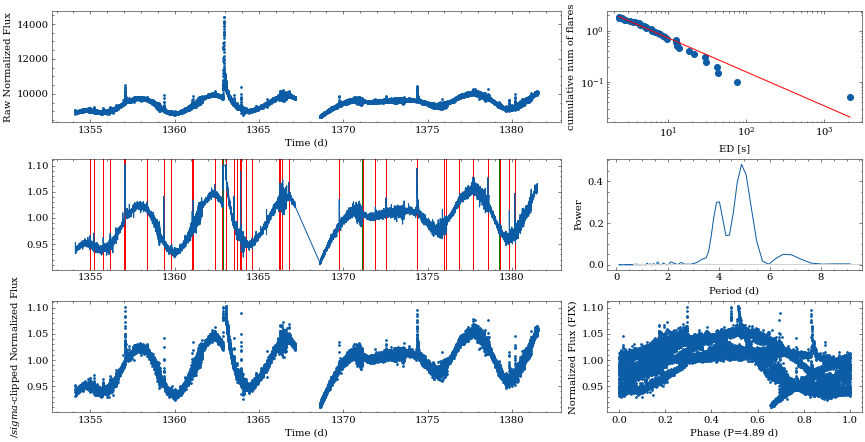

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 5 candidate(s) in the (0,25490) gap.
Found 17 candidate(s) in the (25490,66884) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 22.
Setting frequency values with new values, size 22.
Setting frequency adjusted count values with new values, size 22.


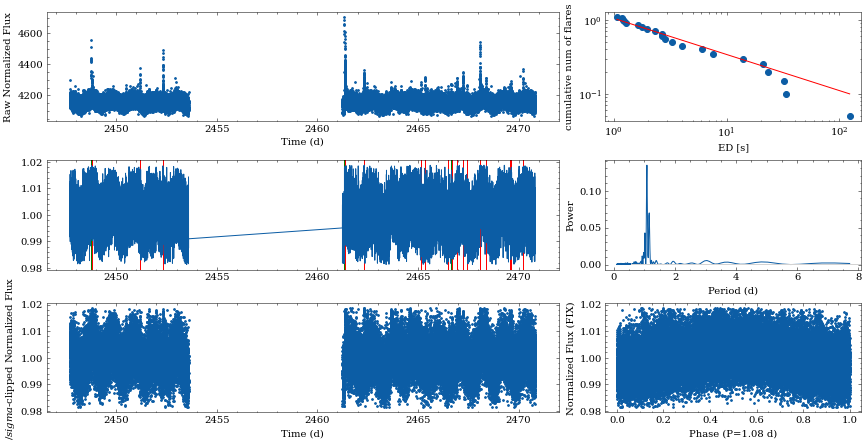

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 4 candidate(s) in the (0,9225) gap.
Found 2 candidate(s) in the (9225,18299) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 6.
Setting frequency values with new values, size 6.
Setting frequency adjusted count values with new values, size 6.


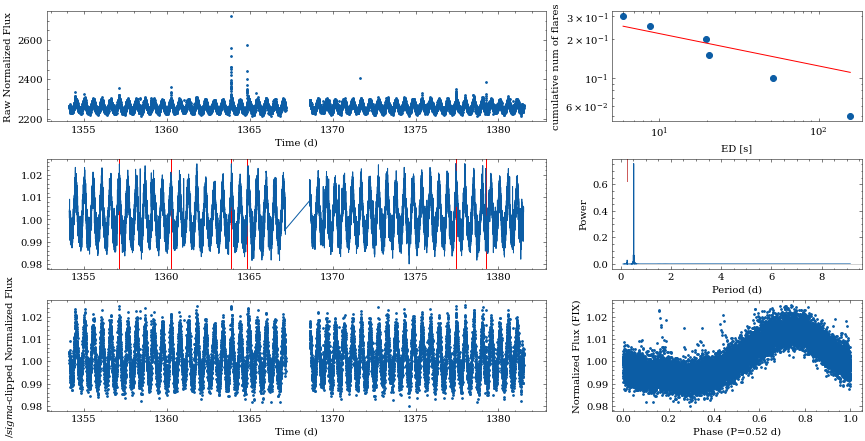

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 2 candidate(s) in the (0,8553) gap.
Found 3 candidate(s) in the (8553,17250) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 5.
Setting frequency values with new values, size 5.
Setting frequency adjusted count values with new values, size 5.


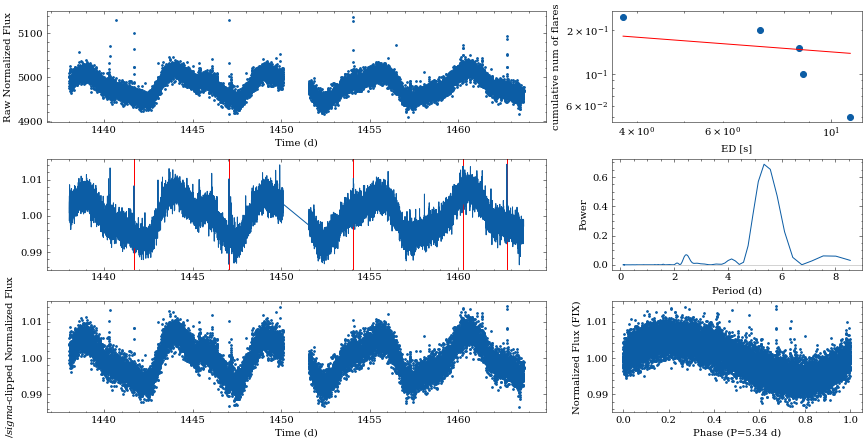

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 9 candidate(s) in the (0,9226) gap.
Found 8 candidate(s) in the (9226,18300) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 17.
Setting frequency values with new values, size 17.
Setting frequency adjusted count values with new values, size 17.


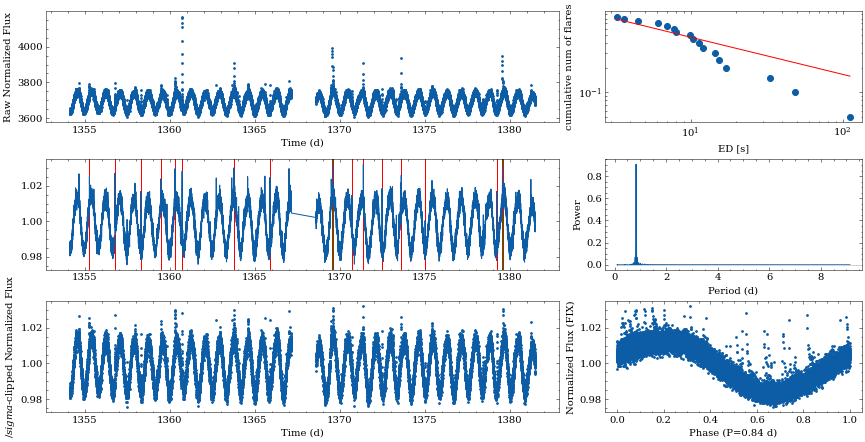

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 8 candidate(s) in the (0,9409) gap.
Found 6 candidate(s) in the (9409,18277) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 14.
Setting frequency values with new values, size 14.
Setting frequency adjusted count values with new values, size 14.


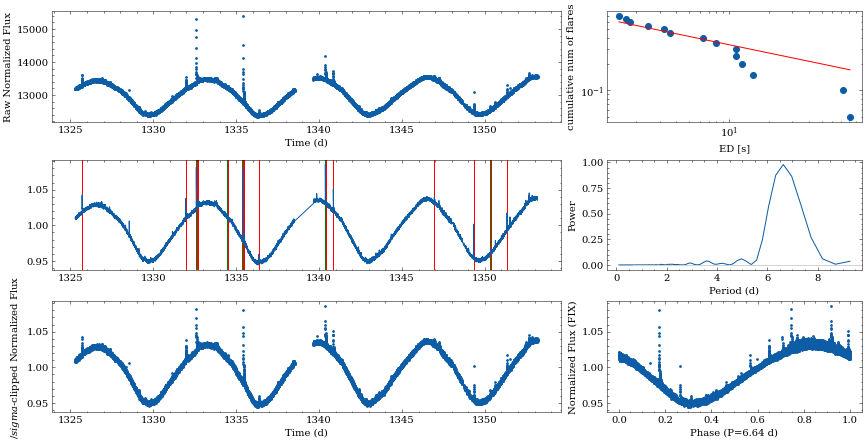

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 5 candidate(s) in the (0,6089) gap.
Found 7 candidate(s) in the (6089,12903) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 12.
Setting frequency values with new values, size 12.
Setting frequency adjusted count values with new values, size 12.


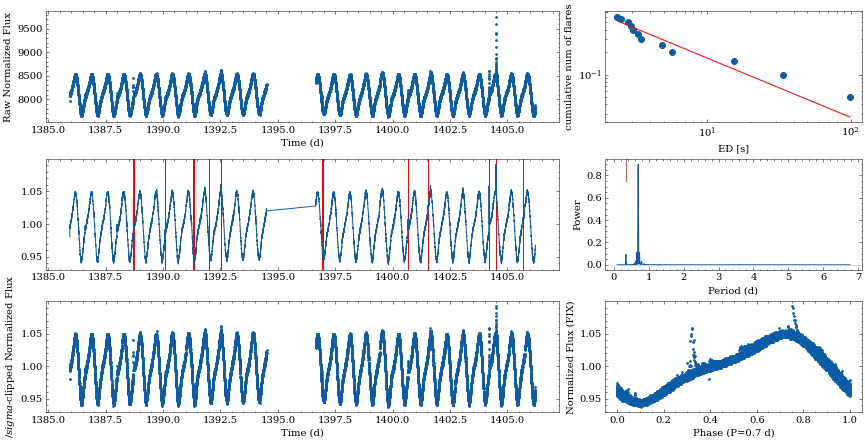

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 6 candidate(s) in the (0,5292) gap.
Found 0 candidate(s) in the (5292,6042) gap.
Found 7 candidate(s) in the (6042,14411) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 13.
Setting frequency values with new values, size 13.
Setting frequency adjusted count values with new values, size 13.


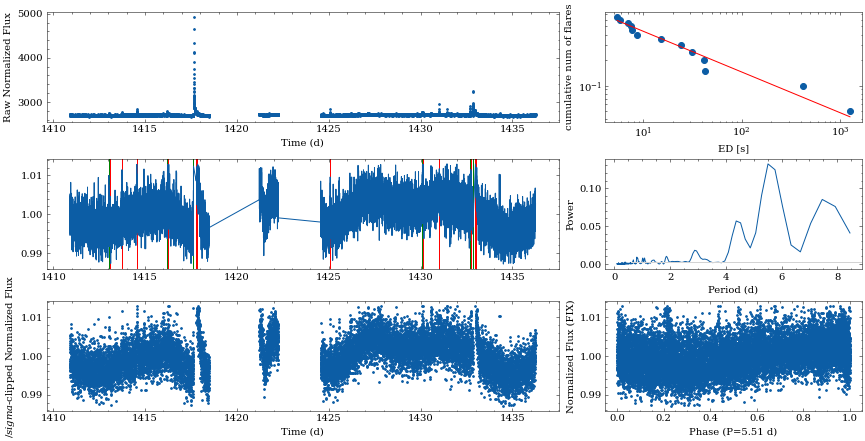

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,5589) gap.
Found 0 candidate(s) in the (5589,12910) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 0.
Setting frequency values with new values, size 0.
Setting frequency adjusted count values with new values, size 0.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:468: RuntimeWarning: Mean of empty slice.
  alpha = _alpha.mean()
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


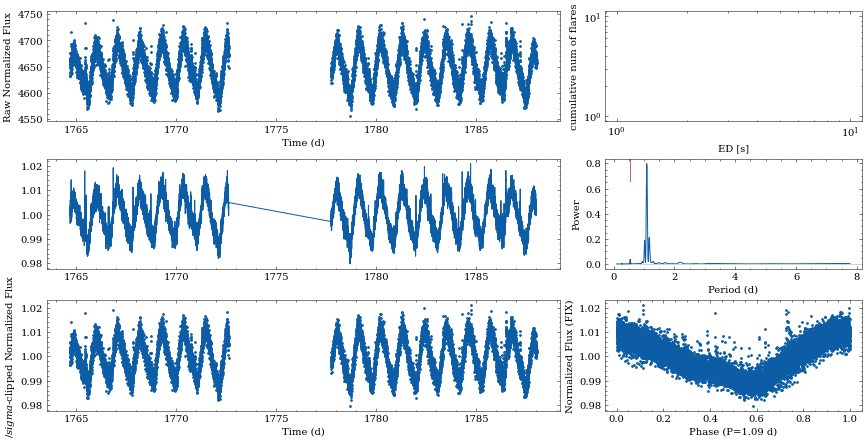

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 2 candidate(s) in the (0,623) gap.
Found 5 candidate(s) in the (623,1237) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 7.
Setting frequency values with new values, size 7.
Setting frequency adjusted count values with new values, size 7.


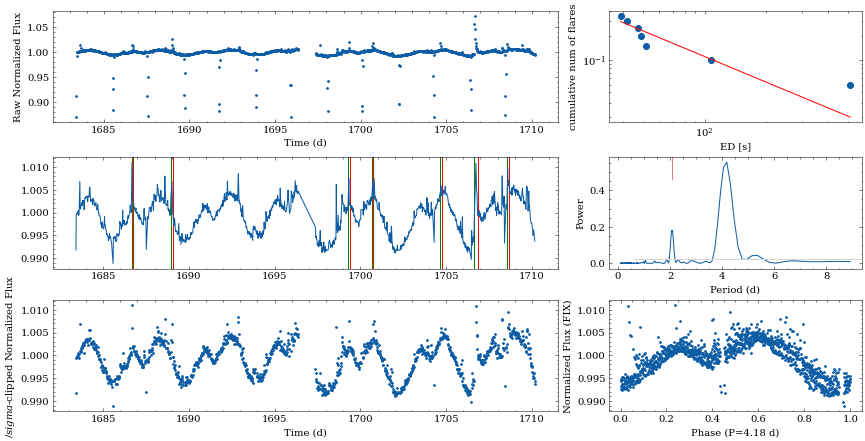

C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\lightkurve\lightcurve.py:226: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  LightkurveDeprecationWarning,
Found 0 candidate(s) in the (0,669) gap.
Found 0 candidate(s) in the (669,1266) gap.
No total observing time given. Set to 1. You are now working with number counts instead of frequency.
Setting ED with new values, size 0.
Setting frequency values with new values, size 0.
Setting frequency adjusted count values with new values, size 0.
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\altaipony\ffd.py:468: RuntimeWarning: Mean of empty slice.
  alpha = _alpha.mean()
C:\Users\60002\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


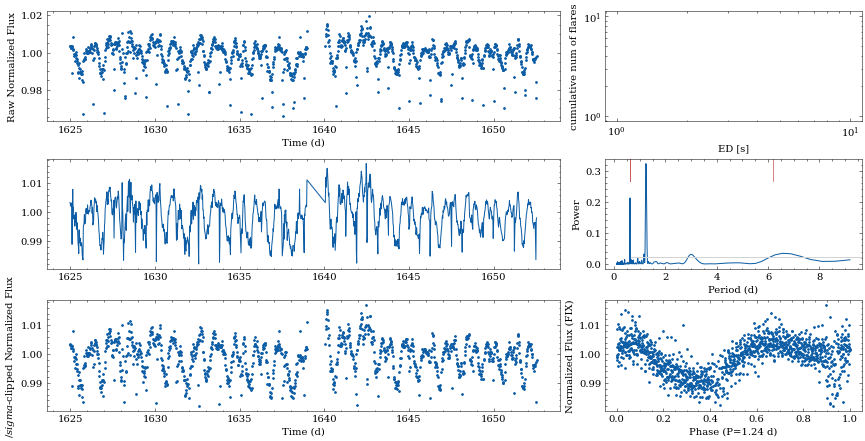

In [8]:
tic_ids = pd.read_csv('C:/Users/60002/Documents/GitHub/sunnyhills/data/knownids.csv')
for id in tic_ids['TIC_ID']:
   lc_dir = 'C:/Users/60002/Documents/GitHub/sunnyhills/data/LightCurve_keys'
   id =int(id)
   make_plot(str(id), lc_dir)

In [ ]:
df = pd.DataFrame({'ID':ids,'Top_Period':top_periods,'Top_Period_Power':top_period_powers,'Fap_99':fap_99s,'Is_Harmonic':is_harmonic,'Num_Flares':num_flares,'Is_Powerlaw':is_powerlaw})
df.to_csv('C:/Users/60002/Documents/GitHub/sunnyhills/data/mosaic_key.csv')
